### load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts

# Milestone 1

## read in the data, convert the dtypes

In [2]:
data=pd.read_csv('H1.csv', converters={'ArrivalDateWeekNumber': '{:0>2}'.format})

In [3]:
data.dtypes

IsCanceled                       int64
LeadTime                         int64
ArrivalDateYear                  int64
ArrivalDateMonth                object
ArrivalDateWeekNumber           object
ArrivalDateDayOfMonth            int64
StaysInWeekendNights             int64
StaysInWeekNights                int64
Adults                           int64
Children                         int64
Babies                           int64
Meal                            object
Country                         object
MarketSegment                   object
DistributionChannel             object
IsRepeatedGuest                  int64
PreviousCancellations            int64
PreviousBookingsNotCanceled      int64
ReservedRoomType                object
AssignedRoomType                object
BookingChanges                   int64
DepositType                     object
Agent                           object
Company                         object
DaysInWaitingList                int64
CustomerType             

In [4]:
dtypes = {
        'IsCanceled': 'float64',
        'LeadTime':'float64',
        'StaysInWeekendNights':'float64',
        'StaysInWeekNights':'float64',
        'Adults':'float64',
        'Children':'float64',
        'Babies':'float64',
        'Meal': 'category',
        'Country': 'category',
        'MarketSegment':'category',
        'DistributionChannel': 'category',
        'IsRepeatedGuest':'float64',
        'PreviousCancellations':'float64',
        'PreviousBookingsNotCanceled': 'float64',
        'ReservedRoomType':'category',
        'AssignedRoomType': 'category',
        'BookingChanges':'float64',
        'DepositType':'category',
        'Agent': 'category',
        'Company':'category',
        'DaysInWaitingList': 'float64',
        'CustomerType':'category',
        'ADR':'float64',
        'RequiredCarParkingSpaces':'float64',
        'TotalOfSpecialRequests': 'float64',
        'ReservationStatus':'category'
        }

In [5]:
data = data.astype(dtypes).copy()

### keep year and month (joined), and cancellatations

In [6]:
data.sort_values(by=['ArrivalDateYear','ArrivalDateWeekNumber'])

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0.0,342.0,2015,July,27,1,0.0,0.0,2.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
1,0.0,737.0,2015,July,27,1,0.0,0.0,2.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
2,0.0,7.0,2015,July,27,1,0.0,1.0,1.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
3,0.0,13.0,2015,July,27,1,0.0,1.0,1.0,0.0,...,No Deposit,304,NULL,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
4,0.0,14.0,2015,July,27,1,0.0,2.0,2.0,0.0,...,No Deposit,240,NULL,0.0,Transient,98.00,0.0,1.0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0.0,212.0,2017,August,35,31,2.0,8.0,2.0,1.0,...,No Deposit,143,NULL,0.0,Transient,89.75,0.0,0.0,Check-Out,2017-09-10
40056,0.0,169.0,2017,August,35,30,2.0,9.0,2.0,0.0,...,No Deposit,250,NULL,0.0,Transient-Party,202.27,0.0,1.0,Check-Out,2017-09-10
40057,0.0,204.0,2017,August,35,29,4.0,10.0,2.0,0.0,...,No Deposit,250,NULL,0.0,Transient,153.57,0.0,3.0,Check-Out,2017-09-12
40058,0.0,211.0,2017,August,35,31,4.0,10.0,2.0,0.0,...,No Deposit,40,NULL,0.0,Contract,112.80,0.0,1.0,Check-Out,2017-09-14


In [7]:
data_df=pd.DataFrame(data['ArrivalDateYear'].map(str) + data['ArrivalDateWeekNumber'].map(str))
data_df.columns=(['FullDate'])
data_df['IsCanceled']=data['IsCanceled']

In [8]:
data_df

,FullDate,IsCanceled
0,201527,0.0
1,201527,0.0
2,201527,0.0
3,201527,0.0
4,201527,0.0
...,...,...
40055,201735,0.0
40056,201735,0.0
40057,201735,0.0
40058,201735,0.0


### aggregate cancellations per week, in ascending week-order

In [9]:
weekly_cancel=data_df.groupby('FullDate').sum()
weekly_cancel.sort_values(by='FullDate', ascending=True)

,IsCanceled
FullDate,
201527,41.0
201528,48.0
201529,87.0
201530,74.0
201531,101.0
...,...
201731,173.0
201732,140.0
201733,182.0


#### and plot it

Text(0.5, 0, '')

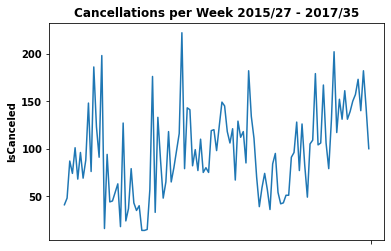

In [10]:
ax=sns.lineplot(data=weekly_cancel, x='FullDate', y ='IsCanceled')
ax.set_title('Cancellations per Week 2015/27 - 2017/35')
ax.set_xticks('')
ax.set_xlabel('')

# Milestone 2

In [61]:
#make a copy
tseries=weekly_cancel.copy()
tseries

,IsCanceled
FullDate,
201527,41.0
201528,48.0
201529,87.0
201530,74.0
201531,101.0
...,...
201731,173.0
201732,140.0
201733,182.0


## Decomposition

In [53]:
decomp=seasonal_decompose(tseries, period=52)

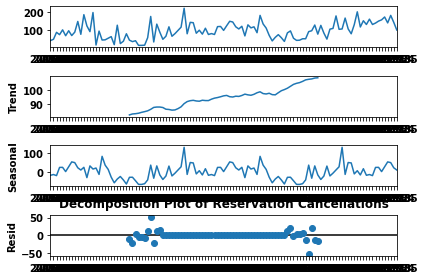

In [71]:
decomp.plot()
plt.title('Decomposition Plot of Reservation Cancellations', y=1.05)
plt.show()

## Autocorrelation and parcial Autocorrelation

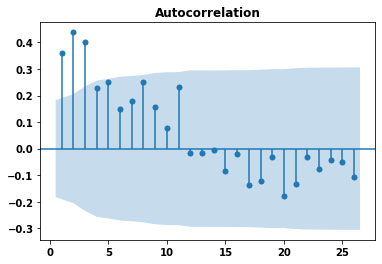

In [76]:
plot_acf(tseries.IsCanceled, lags=26, zero=False)
plt.show()

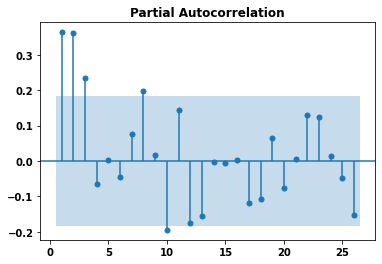

In [77]:
plot_pacf(tseries.IsCanceled, lags=26, zero=False)
plt.show()

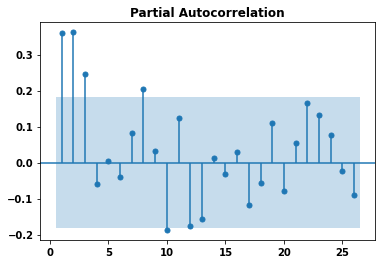

In [78]:
plot_pacf(tseries.IsCanceled, lags=26, method='ols', zero=False)
plt.show()

## Moving Average

In [81]:
# using rolling()-function of pandas
rolling=tseries.rolling(window=4)
rolling_mean=rolling.mean()

Text(0.5, 1.0, 'Moving Average')

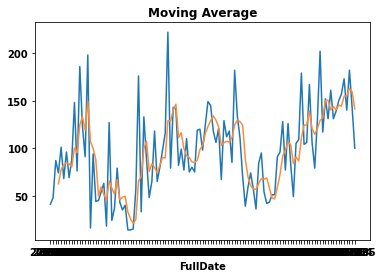

In [92]:
sns.lineplot(data=tseries, legend =False)
sns.lineplot(data=rolling_mean, palette='Oranges',  legend=False)
plt.title('Moving Average')

# train-test-split

In [94]:
len(tseries)*0.9

103.5

In [96]:
train, test=tseries[:104], tseries[104:]